# Risk Model 2 (Market Regime) Feature EDA
    
This notebook analyzes which features are most predictive of **Market Forward Excess Returns**.
The goal is to find leading indicators for market crashes to improve the Market Regime Model.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add project root to path
project_root = Path.cwd().parent
if str(Path.cwd()).endswith('notebooks'):
    sys.path.append(str(project_root))
elif str(Path.cwd()).endswith('scripts'):
    project_root = Path.cwd().parent
    sys.path.append(str(project_root))

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load Data (using pipeline logic to get features)
from src.pipeline import Pipeline
from src.utils import load_config

config = load_config(project_root / 'conf' / 'config.yaml')
train_path = project_root / config['data']['train']

df = pd.read_csv(train_path)

# Load raw data
print("Loading data...")
df = pd.read_csv(train_path)

# Feature Engineering
print("Generating features...")
X = pipeline.feature_engineer.fit_transform(df)

# Target: Market Forward Excess Returns
# Note: This target is future data, so we look for features at time t that correlate with this at t+1
if 'market_forward_excess_returns' in df.columns:
    y_market = df['market_forward_excess_returns']
else:
    print("⚠️ 'market_forward_excess_returns' not found! Using 'forward_returns' as proxy.")
    y_market = df['forward_returns']

# Align indices
common_idx = X.index.intersection(y_market.index)
X = X.loc[common_idx]
y = y_market.loc[common_idx]

print(f"Data Shape: {X.shape}, Target Shape: {y.shape}")


✅ Loaded best parameters for lgbm_return from /Users/gimjunseog/projects/quant_strategy/conf/best_params.yaml
✅ Loaded best parameters for lgbm_risk from /Users/gimjunseog/projects/quant_strategy/conf/best_params.yaml
Loading data...
Generating features...


2025-12-01 16:29:30 - feature_engineering - INFO - Added time series features
2025-12-01 16:29:31 - feature_engineering - INFO - Added advanced features
2025-12-01 16:29:31 - feature_engineering - INFO - Added market regime features
2025-12-01 16:29:31 - feature_engineering - INFO - Filled missing values


Data Shape: (9021, 1980), Target Shape: (9021,)


## 1. Top Correlated Features
Identify features with the highest correlation (positive or negative) with the Market Target.


Top 20 Positive Correlations:
V13_mom_1          0.093606
V9_mom_1           0.077429
V7_mom_1           0.068685
P2_mom_1           0.066072
V13                0.059887
V10_mom_1          0.056375
V13_mom_5          0.048090
S5_roll_mean_20    0.043974
S5_lag_2           0.043370
V13_mom_10         0.042495
S5_roll_mean_5     0.041826
V7_mom_5           0.039152
P2_mom_5           0.038657
I9_bb_width        0.038570
S5                 0.038393
E18_mom_1          0.037930
E18_mom_5          0.036520
S5_lag_1           0.035326
D1_mom_5           0.035289
D2_mom_5           0.035289
dtype: float64
Top 20 Negative Correlations:
P8_mom_1         -0.095088
P10_mom_1        -0.089725
E2_mom_1         -0.074443
E3_mom_1         -0.073540
P11_mom_1        -0.069268
M4               -0.064494
P10_mom_5        -0.061432
P11_mom_5        -0.053549
E2_mom_5         -0.051398
M4_macd_hist     -0.048086
M4_mom_10        -0.047830
P8_mom_5         -0.047042
P10_mom_10       -0.042303
E3_mom_5      

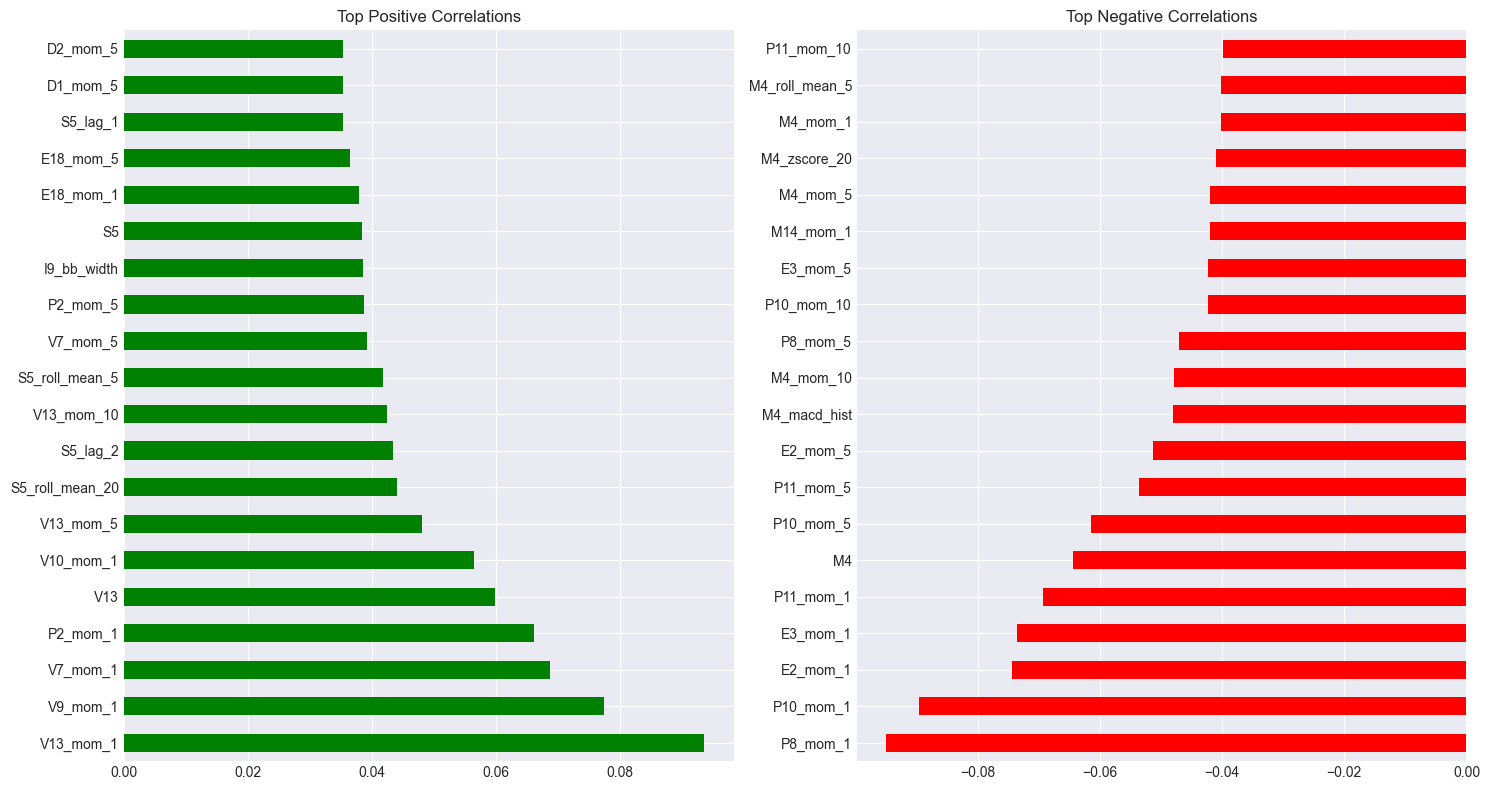

In [6]:
# Calculate correlations
correlations = X.corrwith(y)

# Top 20 Positive
top_pos = correlations.sort_values(ascending=False).head(20)
print("Top 20 Positive Correlations:")
print(top_pos)

# Top 20 Negative
top_neg = correlations.sort_values(ascending=True).head(20)
print("Top 20 Negative Correlations:")
print(top_neg)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
top_pos.plot(kind='barh', ax=ax[0], color='green', title='Top Positive Correlations')
top_neg.plot(kind='barh', ax=ax[1], color='red', title='Top Negative Correlations')
plt.tight_layout()
plt.show()


## 2. Market Specific Features
Check how well the explicitly created market features (volatility, MA trends) correlate.


Found 6 market features: ['market_vol_20d', 'market_vol_60d', 'market_regime_vol', 'market_ma_20d', 'market_ma_60d', 'market_regime_trend']
market_vol_20d         0.014782
market_vol_60d         0.013899
market_regime_vol      0.007196
market_regime_trend   -0.000130
market_ma_60d         -0.031977
market_ma_20d         -0.032387
dtype: float64


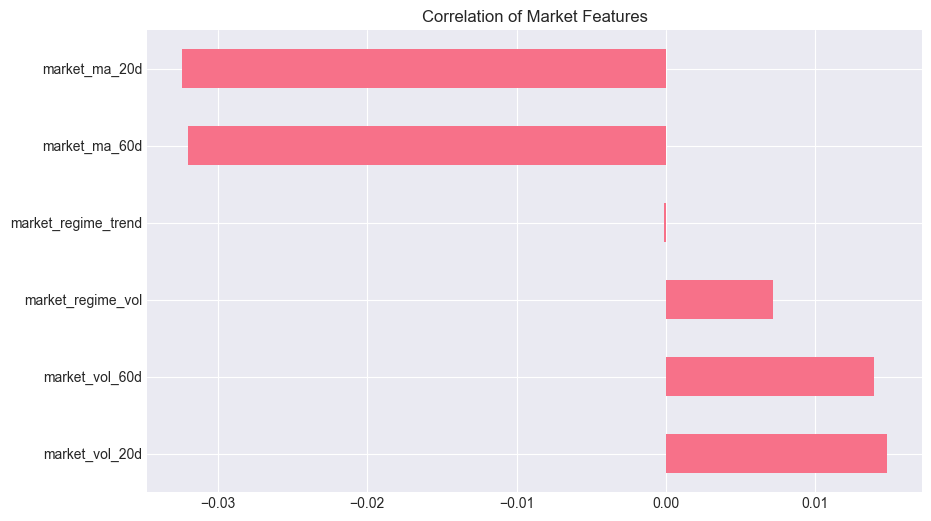

In [7]:
market_cols = [c for c in X.columns if 'market_' in c]
if market_cols:
    print(f"Found {len(market_cols)} market features: {market_cols}")
    market_corr = correlations[market_cols].sort_values(ascending=False)
    print(market_corr)
    
    market_corr.plot(kind='barh', figsize=(10, 6), title="Correlation of Market Features")
    plt.show()
else:
    print("No 'market_' features found in X.")


## 3. Crash Analysis
Let's look specifically at the worst market days (Crashes). Which features signaled them?


In [ ]:
# Define Crash: Bottom 5% of market returns
crash_threshold = y.quantile(0.05)
crash_mask = y < crash_threshold
print(f"Crash Threshold: {crash_threshold:.4f} (Bottom 5%)")
print(f"Number of Crash Days: {crash_mask.sum()}")

# Compare Feature Means: Crash vs Normal
crash_means = X[crash_mask].mean()
normal_means = X[~crash_mask].mean()

# Calculate Divergence (Z-score like difference)
# (Crash Mean - Normal Mean) / Overall Std
divergence = (crash_means - normal_means) / X.std()

# Top Divergent Features (Features that look most different during crashes)
top_div = divergence.abs().sort_values(ascending=False).head(20)
print("Top Divergent Features during Crashes:")
print(top_div)

# Plot Top 5 Divergent Features Distribution
top_5_div = top_div.head(5).index
plt.figure(figsize=(15, 10))
for i, col in enumerate(top_5_div):
    plt.subplot(2, 3, i+1)
    sns.kdeplot(X.loc[~crash_mask, col], label='Normal', fill=True, alpha=0.3)
    sns.kdeplot(X.loc[crash_mask, col], label='Crash', fill=True, alpha=0.3)
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()


SyntaxError: unterminated string literal (detected at line 17) (57970641.py, line 17)